<center><h1>🎬 Movie Recommendation</h1></center>

## 🛠️ Necessary Libraries

To install the necessary libraries for the project, run the following command:

```bash
pip install pandas numpy scikit-learn seaborn matplotlib

### Importing necessary libraries

In [8]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

### 🧹 Loading and Preparing Movie Metadata

We begin by loading the `movies_metadata.csv` file, which contains various attributes for a large collection of movies. From this dataset, we extract only the necessary columns:  

- `title`: The movie's name  
- `genres`: A list of genres (in JSON-like format)  
- `overview`: A short description of the movie  
- `poster_path`: The relative path to the movie's poster image  
- `release_date`: The movie's release date  
- `vote_average`: The average user rating  
- `popularity`: A popularity metric provided by TMDB  

To prepare the data:
- We drop any rows with missing values in the essential columns.
- We then construct a full URL for each movie's poster using TMDB’s base path (`https://image.tmdb.org/t/p/w500`) combined with the `poster_path`.

This cleaned and structured data will serve as the foundation for genre parsing, clustering, and recommendations.


In [9]:
# Load the movie metadata CSV file
df = pd.read_csv("movies_metadata.csv", low_memory=False)

# Select necessary columns
movies = df[['title', 'genres', 'overview', 'poster_path', 'release_date', 'vote_average', 'popularity']].copy()
movies = movies.dropna(subset=['genres', 'vote_average', 'popularity', 'overview', 'poster_path'])
movies['poster_url'] = "https://image.tmdb.org/t/p/w500" + movies['poster_path']

### 📊 Feature Engineering and Clustering Preparation

To prepare our movie data for clustering, we perform the following steps:

1. **Genre Parsing**:  
   The `genres` column is stored as a stringified list of dictionaries. We parse this to extract only the genre names, which are more suitable for machine learning.

2. **Genre Encoding**:  
   We use `MultiLabelBinarizer` to convert each list of genres into a binary format (one-hot encoding), creating a feature column for each genre.

3. **Normalization**:  
   The `vote_average` and `popularity` features are scaled to a 0–1 range using `MinMaxScaler`, so that they are on a comparable scale with the binary genre features.

4. **Feature Combination**:  
   We concatenate the encoded genre features with the normalized numerical features into a single DataFrame, `final_features`, which will be used for clustering.

5. **Finding Optimal Clusters**:  
   We fit KMeans models for `k` values from 2 to 20, and compute:
   - **Inertia** (sum of squared distances to cluster centers): Lower values indicate tighter clusters.
   - **Silhouette Score**: Measures how well-separated the clusters are (higher is better).

6. **Visualization**:  
   We use two plots to help determine the optimal value of `k`:
   - **Elbow Plot**: Helps identify the point where adding more clusters stops improving inertia significantly.
   - **Silhouette Plot**: Helps find the number of clusters with the best overall cluster separation.

These steps ensure that the data is clean, well-scaled, and suitable for effective clustering.


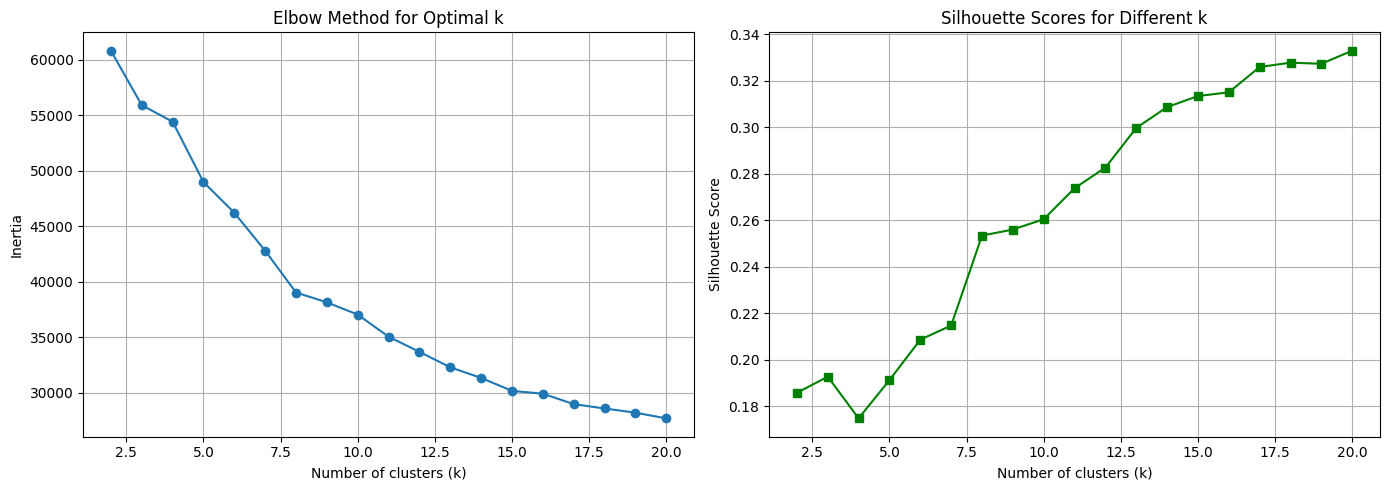

In [10]:
# Parse the 'genres' column to extract genre names
def parse_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

movies['genre_list'] = movies['genres'].apply(parse_genres)

# Encode genres as binary features
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

# Normalize vote_average and popularity
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(movies[['vote_average', 'popularity']])
scaled_df = pd.DataFrame(scaled_features, columns=['vote_average', 'popularity'])

# Combine all features
final_features = pd.concat([genre_df, scaled_df], axis=1)

# Determine optimal number of clusters using inertia and silhouette score
inertia_values = []
silhouette_scores = []
k_values = range(2, 21)

for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(final_features)
    inertia_values.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(final_features, kmeans_model.labels_))

# Plot Elbow and Silhouette scores
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(k_values, inertia_values, marker='o')
axs[0].set_title('Elbow Method for Optimal k')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

axs[1].plot(k_values, silhouette_scores, marker='s', color='green')
axs[1].set_title('Silhouette Scores for Different k')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Silhouette Score')
axs[1].grid(True)

plt.tight_layout()
plt.show()

### 📈 Visualizing Genre Distribution

To better understand the composition of our movie dataset, we plot the distribution of movie genres:

- We first **explode** the `genre_list` column, which contains lists of genres per movie, into individual rows.
- Then we **count** how often each genre appears across all movies.
- A **bar plot** is created to visualize the frequency of each genre.

This visualization helps us identify which genres are most and least represented in the dataset, which may influence clustering and recommendation outcomes.

ipykernel_8488\2703205404.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


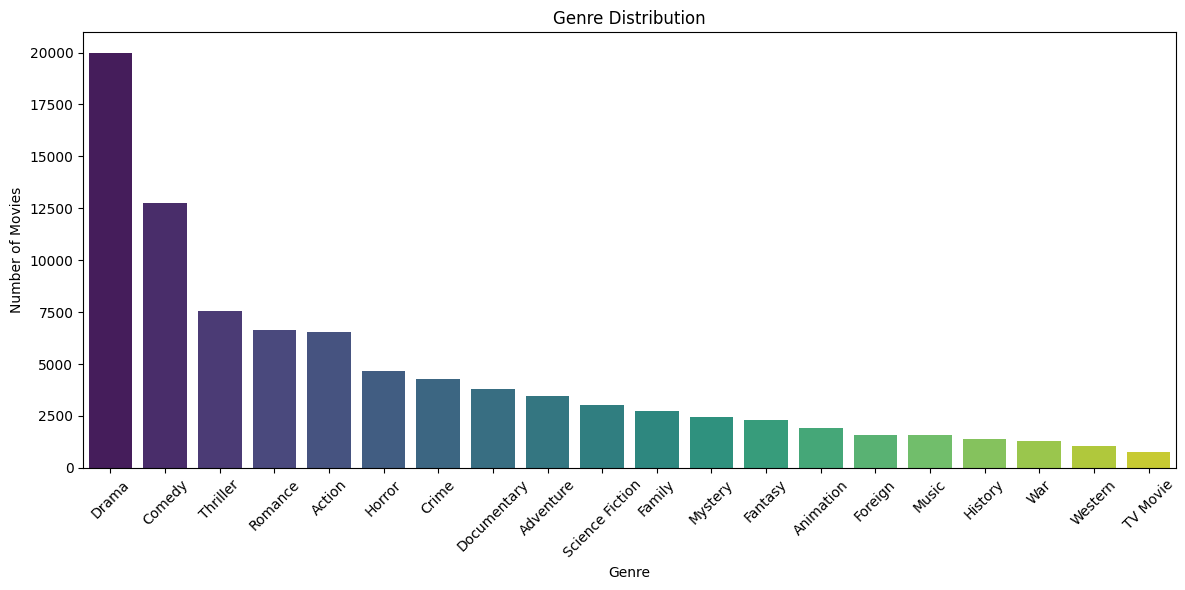

In [11]:
# Plot genre distribution
genre_counts = movies['genre_list'].explode().value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Movies')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

### 🤖 Applying Final KMeans Clustering and Visualizing Cluster Sizes

After analyzing the Elbow and Silhouette plots, we apply KMeans clustering with the chosen number of clusters (`k = 10`).

- Each movie is assigned to one of the 10 clusters based on its genre and normalized feature values.
- We then visualize how many movies fall into each cluster using a bar plot.

This distribution gives us insight into how the clustering algorithm has grouped the movies—whether some clusters dominate or the data is more evenly distributed. This can help us evaluate the balance and effectiveness of our clustering approach.

ipykernel_8488\3554722561.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=movies['cluster'], palette='coolwarm')


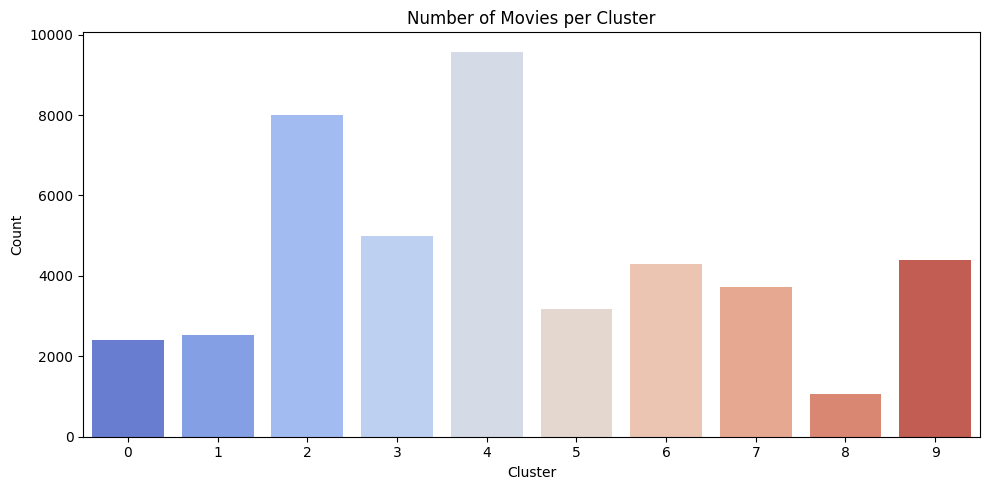

In [12]:
# Fit final KMeans model
optimal_k = 10  # Or choose based on Elbow/Silhouette plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
movies['cluster'] = kmeans.fit_predict(final_features)

# Plot number of movies per cluster
plt.figure(figsize=(10, 5))
sns.countplot(x=movies['cluster'], palette='coolwarm')
plt.title('Number of Movies per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 🎬 Movie Recommendation Based on Clustering

In this section, we implement a simple content-based recommendation function that suggests movies similar to a given title using the clustering results.

### How it works:
- The function `recommend_movies()` takes a movie title as input.
- It identifies the cluster to which the given movie belongs.
- It then selects other movies from the **same cluster**, excluding the target movie itself.
- These movies are sorted by **vote average** and **popularity**, and the top `n` recommendations are returned.

This method assumes that movies within the same cluster share similar characteristics in terms of genre and popularity/ratings.

### Example:
We demonstrate this by recommending 5 movies similar to the title `"War"`.

In [13]:
# Recommendation function
def recommend_movies(movie_title, n=5):
    target = movies[movies['title'].str.lower() == movie_title.lower()]
    if target.empty:
        return f"Movie titled '{movie_title}' not found in dataset."
    
    cluster_id = target['cluster'].values[0]
    similar_movies = movies[(movies['cluster'] == cluster_id) & 
                            (movies['title'].str.lower() != movie_title.lower())]
    
    return similar_movies[['title', 'vote_average', 'popularity']].sort_values(
        by=['vote_average', 'popularity'], ascending=False).head(n)

# Example usage
print("Recommended movies similar to 'War':")
print(recommend_movies("War", n=5))

Recommended movies similar to 'War':
                      title  vote_average popularity
24951  Deliver Us from Evil          10.0   0.317373
39707      American Hostage          10.0    0.11167
31820           Summer City          10.0   0.076562
41767            Life+1 Day           9.4   1.237106
37733           Honey Night           9.3   0.601453


### 🎬 Movie Recommendation with Detailed Information

In this section, we enhance the movie recommendation function to provide more detailed information about the recommended movies.

### How it works:
- The function `recommend_movies()` takes a movie title as input.
- It locates the movie's cluster and finds similar movies within the same cluster.
- For each recommended movie, we include the following details:
  - **Title**
  - **Release Date**
  - **Rating (vote_average)**
  - **Popularity**
  - **Overview**
  - **Poster Image URL**

The recommendations are sorted by **vote_average** and **popularity** to ensure that the highest-rated and most popular movies are suggested first.

### Example:
We demonstrate the function by recommending 5 movies similar to `"Iron Man"`, including detailed information like the movie's release date, rating, and overview.

This provides a richer user experience when making movie suggestions, as it includes both textual descriptions and visual poster images.

In [17]:
def recommend_movies(title, n=5):
    match = movies[movies['title'].str.lower() == title.lower()]
    if match.empty:
        return []
    
    cluster = match.iloc[0]['cluster']
    similar = movies[(movies['cluster'] == cluster) & 
                     (movies['title'].str.lower() != title.lower())]

    return similar[['title', 'overview', 'release_date', 'vote_average', 'popularity', 'poster_url']].sort_values(
        by=['vote_average', 'popularity'], ascending=False).head(n).to_dict(orient='records')


results = recommend_movies("iron man", n=5)
for movie in results:
    print(f"🎬 {movie['title']} ({movie['release_date']})")
    print(f"⭐ Rating: {movie['vote_average']} | 🔥 Popularity: {movie['popularity']}")
    print(f"📝 {movie['overview']}")
    print(f"🖼️ Poster: {movie['poster_url']}")
    print("-" * 40)


🎬 Say Nothing (2001-08-01)
⭐ Rating: 9.0 | 🔥 Popularity: 0.229743
📝 Housewife Grace Needham (Nastassja Kinski) has a one-night stand with Julian Grant (William Baldwin), who then becomes obsessed with sinking her marriage to husband Matt (Hart Bochner). The twist here is that Julian is a millionaire global powerbroker, and Matt works for him! It's a titanic battle of testosterone as the guys duke it out while Grace simmers angrily.
🖼️ Poster: https://image.tmdb.org/t/p/w500/e5zFhKKniiiep8oM7Y3g6gLygHS.jpg
----------------------------------------
🎬 I Am So Proud of You (2008-01-01)
⭐ Rating: 8.3 | 🔥 Popularity: 0.472132
📝 Dark shadows are cast over Bill's recovery, in this second chapter to Everything will be OK.
🖼️ Poster: https://image.tmdb.org/t/p/w500/5V02nhJlXdcTUjtRh7b7HLWklbN.jpg
----------------------------------------
🎬 The Empire Strikes Back (1980-05-17)
⭐ Rating: 8.2 | 🔥 Popularity: 19.470959
📝 The epic saga continues as Luke Skywalker, in hopes of defeating the evil Galacti